# Модель классификации


Данная модель  направлена на выполнение бинарной классификации, и с определенной долей вероятности определяет, будет ли в данный день продажа или нет. Для решения поставленной задачи была выбрана модель байесовской сверточной нейронной сети (Bayesian Convolutional Neural Network Model).

In [1]:
import warnings # Чтобы не выводились предупреждения

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import requests
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import os
%matplotlib inline
from datetime import datetime, timedelta


print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')
warnings.filterwarnings("ignore")

Tensorflow version 2.10.0
GPU is ON


## Этап 1. Преобразование данных

Первым этапом выполняется преобразование входных данных в нужный формат. Функция _delete_duplicte автоматически проверяет набор данных и извлекает дублирующиеся строки, затем суммирует их значения, и удалет лишиние данные.

In [2]:
def _delete_duplicte (df):
    df_2 = df.copy()
    for i in range(1, len(df)):
        if df.iloc[i].date == df.iloc[i-1].date:
            df_2 = df_2.drop(df_2[df_2.date == df.iloc[i].date].index)
            n_count = df.iloc[i]['count'] + df.iloc[i-1]['count']
            new_row = {'date':df.iloc[i].date, 'count':n_count}
            df_2 = df_2.append(new_row, ignore_index=True)
    return df_2

Загружаем данные

In [3]:
df = pd.read_csv('96sku265.csv', sep = ",", parse_dates = ['date'])  #
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)

Преобразуем данные

In [4]:
df = _delete_duplicte(df) # Удаляем лишнее
df = df.sort_values(by=['date']) # Сортируем
df = df.reset_index().drop('index', axis=1)
df = df.set_index('date')

# Заполняем пробелы
s = pd.Series(df.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df.reset_index().date)[0], list(df.reset_index().date)[-1]), fill_value=0)


df = s.to_frame(name='count')
df.index.name='date'

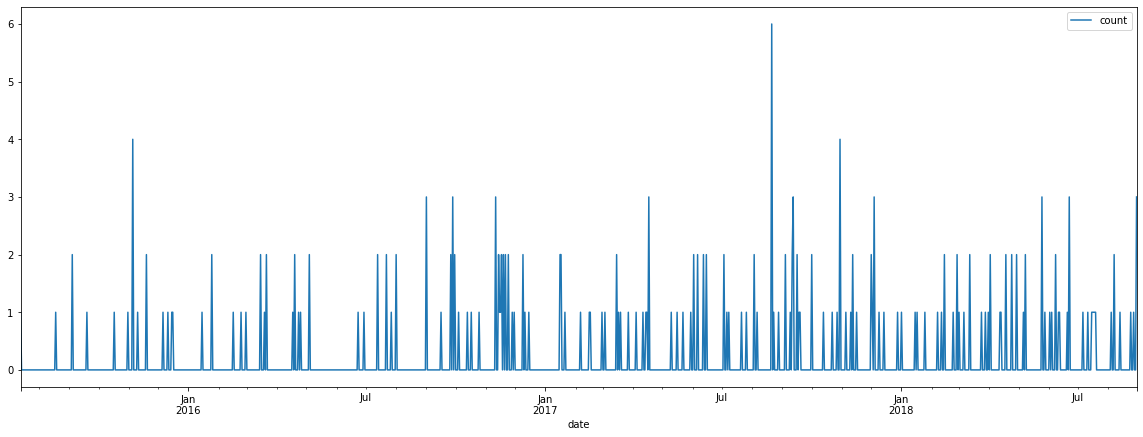

In [5]:
df.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

Переводим полученный датасет в бинарный тип

In [6]:
df_2 = df.copy()

for i in range(1, len(df)):
    if df_2.iloc[i][0] > 0:
        df_2.iloc[i] = 1
#     else:
#          df_2.iloc[i] = -1
df = df_2

Проверяем получившееся

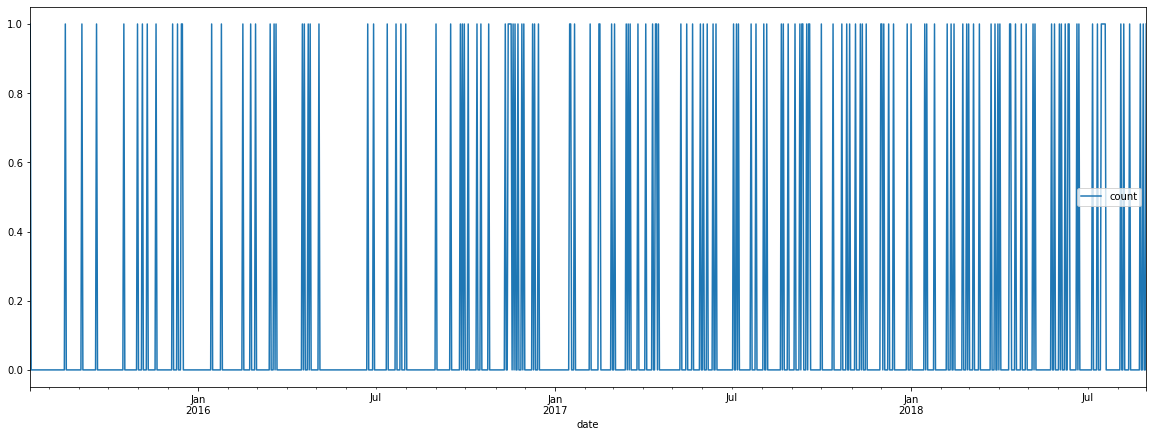

In [7]:
df.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Этап 2. Создаем тестовую и тренировочную выборки

In [8]:
t_point = round(0.7*len(df))
train = df.iloc[:t_point]
test = df.iloc[t_point:]

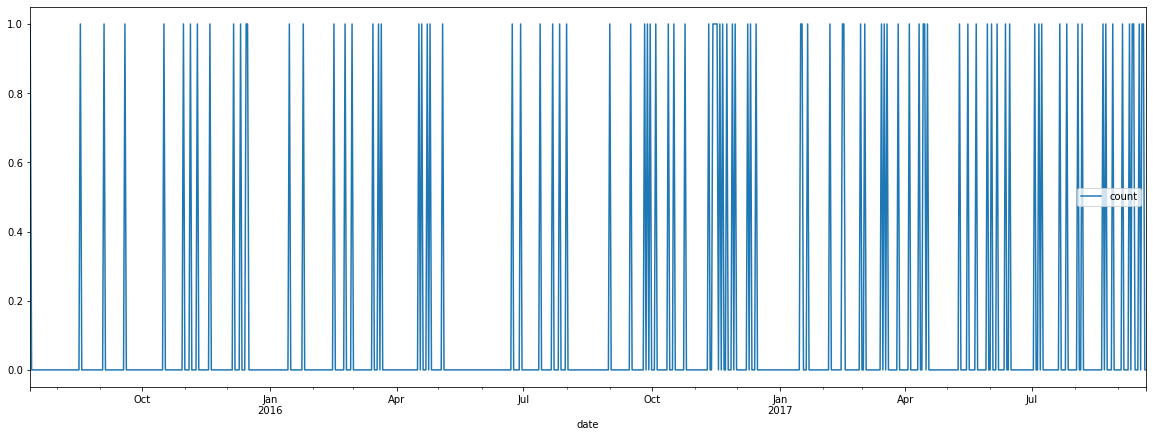

In [9]:
train.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

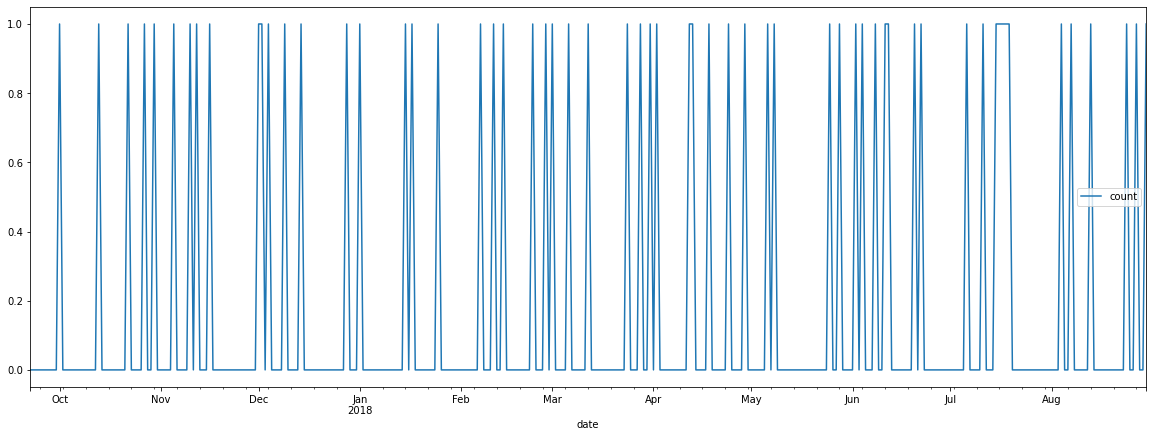

In [10]:
test.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 10
n_features = 1

generator_train = TimeseriesGenerator(np.array(train), np.array(train), length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(np.array(test), np.array(test), length=n_input, batch_size=1)

X,y = generator_train[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1 0 0 0 0 0 0 0 0 0]
Predict this y: 
 [[0]]


## Создаем модель

In [12]:
def buying_score(y_true, y_pred):
    return (1+y_pred)/(1+y_true)

In [13]:
num_classes = len(np.unique(train))

In [14]:
from spec_metric import spec
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, ReLU, SimpleRNN, Lambda, Conv1D, Bidirectional, Dropout, BatchNormalization, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Input(shape=(n_input, n_features)))

model.add(Conv1D(filters=128, kernel_size=3, padding="same"))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, padding="same"))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))


model.add(Conv1D(filters=256, kernel_size=3, padding="same"))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))


model.add(Conv1D(filters=128, kernel_size=3, padding="same"))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=1))

# model.add(Bidirctional(LSTM(30, return_sequences=True)))


model.add(GlobalAveragePooling1D())
model.add(Dense(num_classes, activation = 'softmax'))


model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_crossentropy' ]) #tf.keras.losses.Huber()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 128)           512       
                                                                 
 re_lu (ReLU)                (None, 10, 128)           0         
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 256)            98560     
                                                                 
 re_lu_1 (ReLU)              (None, 5, 256)            0         
                                                        

In [15]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
Checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001)

In [16]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        val_sparse_categorical_accuracy = logs["val_binary_accuracy"]
        if (val_sparse_categorical_accuracy >= self.point):
            self.model.stop_training = True


## Выполняем обучение модели

In [17]:
model.fit(generator_train, epochs=100, callbacks = [lr_schedule, ReduceLR], shuffle = False) #, StopOnPoint(0.82)

Epoch 1/100
792/792 [==============================] - 10s 10ms/step - loss: 0.6937 - binary_crossentropy: 0.6937 - lr: 1.0000e-08
Epoch 2/100
792/792 [==============================] - 8s 9ms/step - loss: 0.6941 - binary_crossentropy: 0.6941 - lr: 1.1220e-08
Epoch 3/100
792/792 [==============================] - 8s 10ms/step - loss: 0.6938 - binary_crossentropy: 0.6938 - lr: 1.2589e-08
Epoch 4/100
792/792 [==============================] - 8s 11ms/step - loss: 0.6937 - binary_crossentropy: 0.6937 - lr: 1.4125e-08
Epoch 5/100
792/792 [==============================] - 8s 11ms/step - loss: 0.6938 - binary_crossentropy: 0.6938 - lr: 1.5849e-08
Epoch 6/100
792/792 [==============================] - 8s 11ms/step - loss: 0.6936 - binary_crossentropy: 0.6936 - lr: 1.7783e-08
Epoch 7/100
792/792 [==============================] - 8s 10ms/step - loss: 0.6937 - binary_crossentropy: 0.6937 - lr: 1.9953e-08
Epoch 8/100
792/792 [==============================] - 8s 11ms/step - loss: 0.6935 - binar

792/792 [==============================] - 8s 11ms/step - loss: 0.3819 - binary_crossentropy: 0.3819 - lr: 1.2589e-05
Epoch 64/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3774 - binary_crossentropy: 0.3774 - lr: 1.4125e-05
Epoch 65/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3726 - binary_crossentropy: 0.3726 - lr: 1.5849e-05
Epoch 66/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3760 - binary_crossentropy: 0.3760 - lr: 1.7783e-05
Epoch 67/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3707 - binary_crossentropy: 0.3707 - lr: 1.9953e-05
Epoch 68/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3661 - binary_crossentropy: 0.3661 - lr: 2.2387e-05
Epoch 69/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3678 - binary_crossentropy: 0.3678 - lr: 2.5119e-05
Epoch 70/100
792/792 [==============================] - 8s 10ms/step - loss: 0.3670 - binary_cro

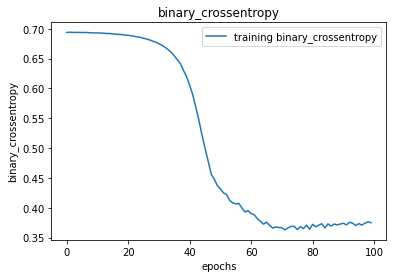

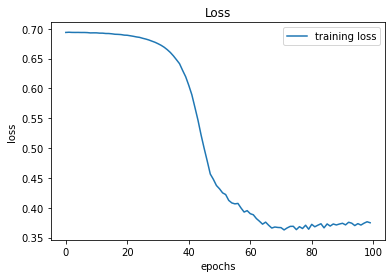

In [18]:
plt.figure(0)
plt.plot(model.history.history['binary_crossentropy'], label='training binary_crossentropy')
# plt.plot(model.history.history['val_binary_crossentropy'], label='validation binary_crossentropy')
plt.title('binary_crossentropy')
plt.xlabel('epochs')
plt.ylabel('binary_crossentropy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
# plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Тестируем полученную модель

## Эксперимент 1

Первым этапом тестируем полученную модель на тестовой выборке

In [20]:
test_predictions = []
first_eval_batch = np.array(test)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    test_predictions.append(np.array(test)[i]) 
    
try:
    for i in range(len(test)-3):
        current_pred = model.predict(current_batch)
        print(current_pred)
        current_pred = np.argmax(current_pred) #round(current_pred[0][0])
        print(current_pred)
        test_predictions.append([current_pred])
        current_batch = np.append(current_batch[:,1:,:],[[np.array(test)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 135ms/step
[[0.5060146  0.49398535]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50090736 0.49909264]]
0
1/1 [==============================] - 0s 16ms/step
[[0.492903   0.50709695]]
1
1/1 [==============================] - 0s 17ms/step
[[0.50216377 0.49783617]]
0
1/1 [==============================] - 0s 16ms/step
[[0.49322563 0.50677437]]
1
1/1 [==============================] - 0s 16ms/step
[[0.50318223 0.49681777]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50075877 0.49924123]]
0
1/1 [==============================] - 0s 16ms/step
[[0.5079684 0.4920316]]
0
1/1 [==============================] - 0s 16ms/step
[[0.5135349  0.48646507]]
0
1/1 [==============================] - 0s 16ms/step
[[0.51165324 0.4883468 ]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50357187 0.4964281 ]]
0
1/1 [==============================] - 0s 17ms/step
[[0.50357187 0.4964281 ]]
0
1/1 [==============================] - 0s

1/1 [==============================] - 0s 16ms/step
[[0.50357187 0.4964281 ]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50357187 0.4964281 ]]
0
1/1 [==============================] - 0s 17ms/step
[[0.50357187 0.4964281 ]]
0
1/1 [==============================] - 0s 17ms/step
[[0.5060146  0.49398535]]
0
1/1 [==============================] - 0s 17ms/step
[[0.50090736 0.49909264]]
0
1/1 [==============================] - 0s 17ms/step
[[0.50258 0.49742]]
0
1/1 [==============================] - 0s 16ms/step
[[0.499857   0.50014305]]
1
1/1 [==============================] - 0s 17ms/step
[[0.49724495 0.502755  ]]
1
1/1 [==============================] - 0s 17ms/step
[[0.5019546  0.49804538]]
0
1/1 [==============================] - 0s 17ms/step
[[0.49992552 0.5000745 ]]
1
1/1 [==============================] - 0s 17ms/step
[[0.50980365 0.49019635]]
0
1/1 [==============================] - 0s 17ms/step
[[0.50972074 0.49027926]]
0
1/1 [==============================] - 0s 17ms

1/1 [==============================] - 0s 16ms/step
[[0.50314105 0.49685892]]
0
1/1 [==============================] - 0s 15ms/step
[[0.49867684 0.50132316]]
1
1/1 [==============================] - 0s 16ms/step
[[0.50993305 0.49006698]]
0
1/1 [==============================] - 0s 15ms/step
[[0.49322563 0.50677437]]
1
1/1 [==============================] - 0s 17ms/step
[[0.503744   0.49625602]]
0
1/1 [==============================] - 0s 16ms/step
[[0.5023482 0.4976518]]
0
1/1 [==============================] - 0s 16ms/step
[[0.49526894 0.50473106]]
1
1/1 [==============================] - 0s 16ms/step
[[0.5192494 0.4807506]]
0
1/1 [==============================] - 0s 16ms/step
[[0.5000204  0.49997962]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50318223 0.49681777]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50075877 0.49924123]]
0
1/1 [==============================] - 0s 16ms/step
[[0.5079898  0.49201012]]
0
1/1 [==============================] - 0s 15

1/1 [==============================] - 0s 17ms/step
[[0.492903   0.50709695]]
1
1/1 [==============================] - 0s 16ms/step
[[0.50333273 0.4966673 ]]
0
1/1 [==============================] - 0s 17ms/step
[[0.49675992 0.50324005]]
1
1/1 [==============================] - 0s 16ms/step
[[0.50518346 0.49481648]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50576764 0.49423236]]
0
1/1 [==============================] - 0s 16ms/step
[[0.5142751 0.4857249]]
0
1/1 [==============================] - 0s 16ms/step
[[0.52303123 0.4769688 ]]
0
1/1 [==============================] - 0s 16ms/step
[[0.51435596 0.48564398]]
0
1/1 [==============================] - 0s 16ms/step
[[0.50314105 0.49685892]]
0
1/1 [==============================] - 0s 16ms/step
[[0.49867684 0.50132316]]
1
1/1 [==============================] - 0s 17ms/step
[[0.50993305 0.49006698]]
0
1/1 [==============================] - 0s 16ms/step
[[0.49322563 0.50677437]]
1
1/1 [==============================] - 0s 

In [21]:
test_predictions

[array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]

In [22]:
test_copy = test.copy()
test_copy['Predictions'] = np.array(test_predictions)
test_copy

,count,Predictions
date,,
2017-09-22,0,0
2017-09-23,0,0
2017-09-24,0,0
2017-09-25,0,0
2017-09-26,0,0
...,...,...
2018-08-26,0,1
2018-08-27,1,0
2018-08-28,0,1


<AxesSubplot:xlabel='date'>

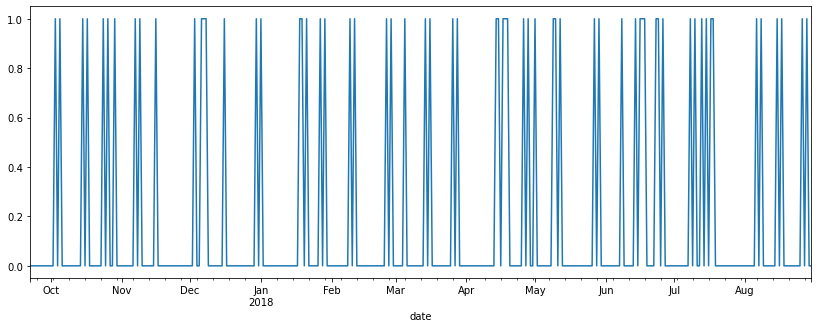

In [23]:
test_copy['Predictions'].plot(figsize=(14,5))


<AxesSubplot:xlabel='date'>

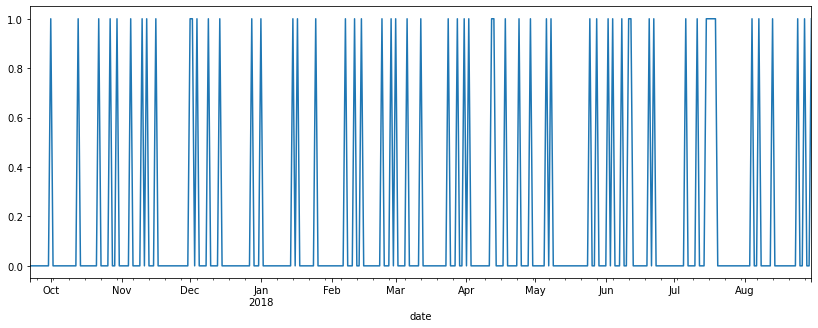

In [24]:
test_copy['count'].plot(figsize=(14,5))


<AxesSubplot:xlabel='date'>

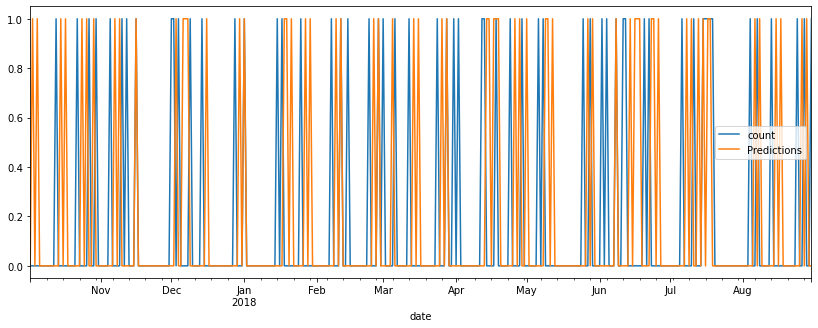

In [25]:
test_copy[n_input:].plot(figsize=(14,5))


In [26]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy['count']),list(test_copy['Predictions'])):
#     if y_true != y_pred:
#         print(y_true, y_pred, buying_score(y_true, y_pred))
    metric_list.append(buying_score(y_true, y_pred))

In [27]:
mean(metric_list)

1.0845481049562682

In [28]:
Bought = sum(list(test_copy['Predictions'][n_input:]))
Sold = sum(list(test_copy['count'][n_input:]))
Bought, Sold

(64, 59)

In [29]:
print('Перезакуп {}'.format (Bought - Sold)) if Bought/Sold > 1 else print('Недозакуп {}'.format (Bought - Sold))

Перезакуп 5


In [30]:
Bought/Sold

1.0847457627118644

## Эксперимент 2
Тестируем полученную модель на наборе данных с низкочастотной номенклуатурой

In [31]:
df_2 = pd.read_csv('42sku13653.csv', sep = ",", parse_dates = ['date']) # 

In [32]:
df_2 = _delete_duplicte(df_2)
df_2 = df_2.sort_values(by=['date'])
df_2 = df_2.reset_index().drop('index', axis=1)
date = df_2['date']
df_2 =df_2.set_index('date')
s = pd.Series(df_2.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df_2.reset_index().date)[0], list(df_2.reset_index().date)[-1]), fill_value=0)
df_2 = s.to_frame(name='count')

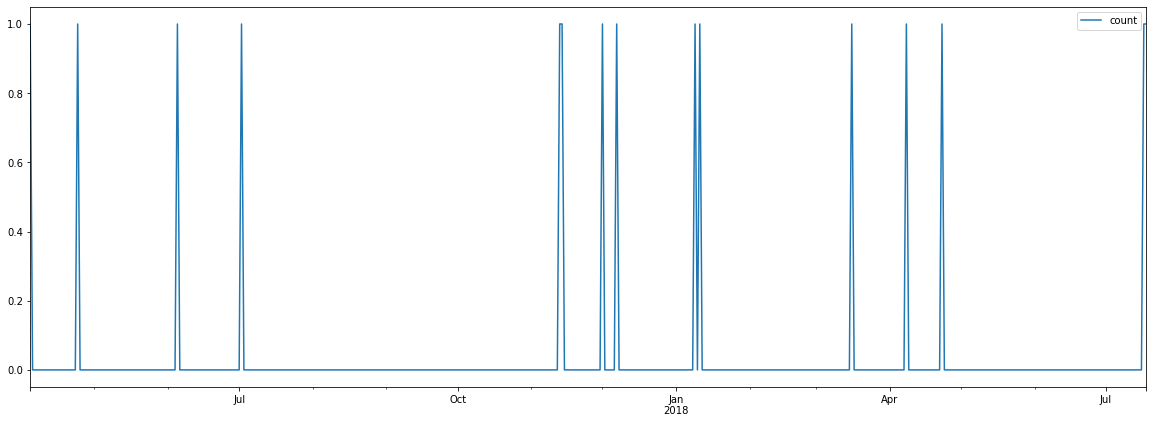

In [33]:
df_2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [34]:
df2_predictions = []
first_eval_batch = np.array(df_2)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    df2_predictions.append(np.array(df_2)[i][0]) 
    
try:
    for i in range(len(np.array(df_2))-3):
        current_pred = model.predict(current_batch)
        current_pred = np.argmax(current_pred) #round(current_pred[0][0])
        print(current_pred)
        df2_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[np.array(df_2)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0


In [35]:
test_copy_DF2 = df_2.copy()
test_copy_DF2['Predictions'] = np.array(df2_predictions)
test_copy_DF2

,count,Predictions
2017-04-04,1,1
2017-04-05,0,0
2017-04-06,0,0
2017-04-07,0,0
2017-04-08,0,0
...,...,...
2018-07-14,0,0
2018-07-15,0,0
2018-07-16,0,0
2018-07-17,1,0


In [36]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_copy_DF2['count'],test_copy_DF2['Predictions'])

0.03876266354329438

In [37]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy_DF2['count']),list(test_copy_DF2['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))
    
mean(metric_list)    

1.0360934182590233

In [38]:
s = sum(list(test_copy_DF2['count']))
b = sum(list(test_copy_DF2['Predictions']))
b-s

10

In [39]:
b/s

1.6666666666666667

<AxesSubplot:>

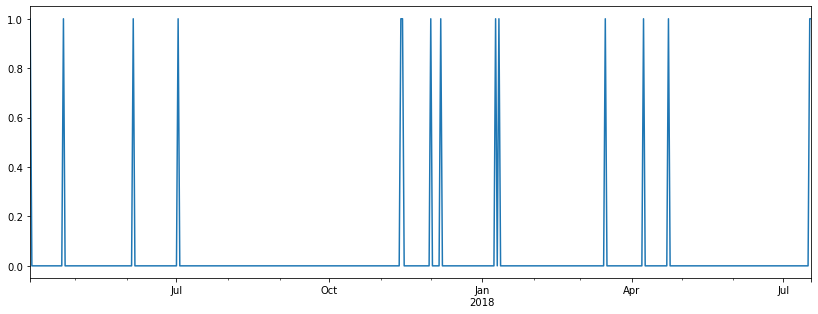

In [40]:
test_copy_DF2['count'].plot(figsize=(14,5))


<AxesSubplot:>

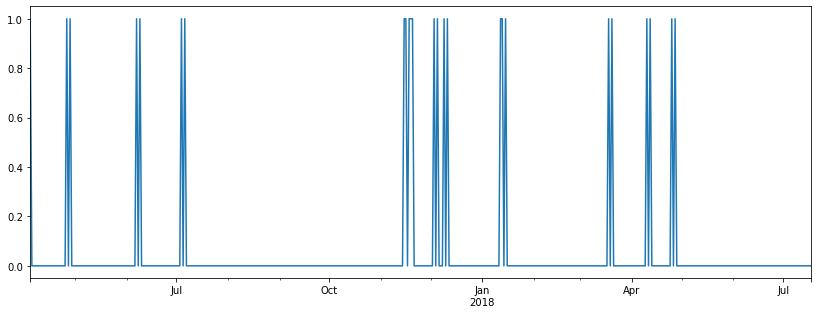

In [41]:
test_copy_DF2['Predictions'].plot(figsize=(14,5))


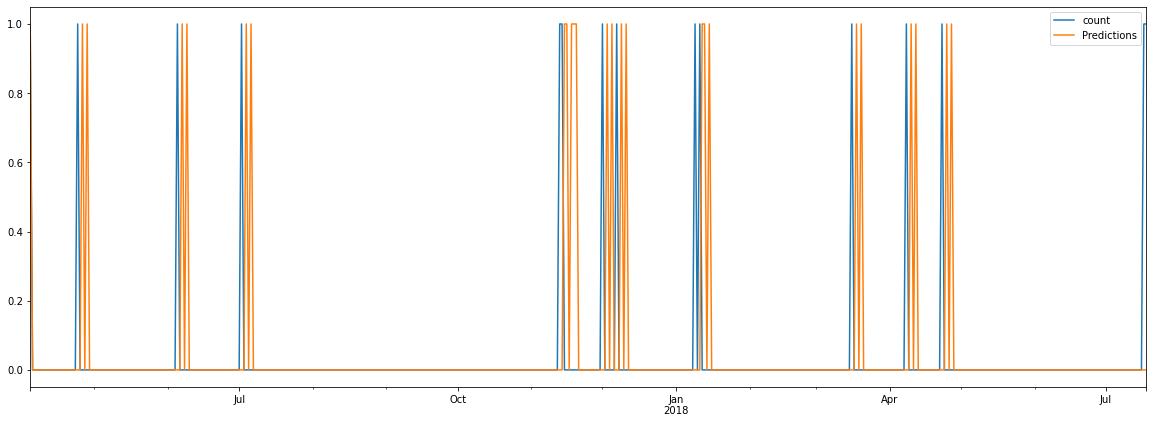

In [42]:
test_copy_DF2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика